In [1]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import warnings
from sqlalchemy import create_engine
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", 300) 

In [3]:
from sqlalchemy import create_engine, text

engine = create_engine(
    "mssql+pyodbc://LAPTOP-TG4UPAEV\\SQLEXPRESS/London Airbnb?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)
airbnb_summary=pd.read_sql("""select * from airbnb_summary_final""",engine)

airbnb_summary.head()

c:\Users\HP\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\io\sql.py:1648: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,quarter,host_info_missing_flag,no_reviews_flag,listing_status,occ_rate_30,revenue_quarter
0,13913,54730,2009-11-16,within an hour,100%,77%,t,3.0,4.0,t,Islington,51.56861,-0.11270,Private room in rental unit,Private room,1,1.0,1.0,1.0,59.0,1,29,29.0,1.0,29.0,t,28,58,88,363,44,4,0,2010-08-18,2024-07-10,4.82,4.74,4.74,4.77,4.84,4.72,4.72,3,2,1,0,0.26,2024Q3,0,0,Active,0.066667,354.0
1,392141,1961043,2012-03-18,within a few hours,100%,60%,t,1.0,1.0,t,Wandsworth,51.44355,-0.19915,Private room in home,Private room,2,1.0,1.0,1.0,65.0,2,50,50.0,2.0,50.0,t,0,0,21,289,28,5,0,2012-05-07,2024-06-16,4.88,4.93,4.89,5.00,5.00,4.81,4.81,1,0,1,0,0.19,2024Q3,0,0,Active,1.000000,5850.0
2,15400,60302,2009-12-05,N/A,unknown,100%,f,1.0,1.0,t,Kensington and Chelsea,51.48780,-0.16813,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,120.0,4,30,30.0,4.0,30.0,t,0,0,0,244,96,2,0,2009-12-21,2024-04-28,4.80,4.86,4.88,4.88,4.84,4.93,4.75,1,1,0,0,0.54,2024Q3,0,0,Active,1.000000,10800.0
3,33332,144444,2010-06-14,N/A,unknown,N/A,f,2.0,2.0,f,Richmond upon Thames,51.46410,-0.32498,Private room in home,Private room,2,1.0,1.0,1.0,140.0,2,21,21.0,2.0,21.0,t,30,60,90,365,19,0,0,2010-10-16,2022-08-01,4.37,4.44,4.56,4.56,4.50,4.67,4.22,2,0,2,0,0.11,2024Q3,0,0,Active,0.000000,0.0
4,493394,2437571,2012-05-22,N/A,unknown,N/A,f,1.0,1.0,f,Greenwich,51.50972,0.11894,Private room in rental unit,Private room,1,1.0,1.0,1.0,75.0,1,1125,1125.0,1.0,1125.0,t,30,60,90,365,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0.00,2024Q3,0,1,Active,0.000000,0.0


# EDA

In [4]:
numeric_cols = ['price','availability_365','number_of_reviews','reviews_per_month','accommodates','bathrooms','bedrooms','beds','minimum_nights','maximum_nights','host_listings_count','review_scores_rating']

airbnb_summary[airbnb_summary["listing_status"] == "Active"] [numeric_cols].describe()

,price,availability_365,number_of_reviews,reviews_per_month,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,host_listings_count,review_scores_rating
count,260416.000000,260417.000000,260417.000000,260417.000000,260417.000000,260417.000000,260413.000000,245326.000000,260417.000000,2.604170e+05,260363.000000,199204.000000
mean,196.709887,198.227366,24.614622,0.962134,3.457136,1.357511,1.541978,1.915777,5.722188,1.232686e+04,46.152399,4.672131
std,759.123927,121.548401,55.071658,1.349426,2.171377,0.749097,1.092359,1.421971,23.953605,2.840975e+06,308.435688,0.507888
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000,0.000000
25%,75.000000,84.000000,1.000000,0.040000,2.000000,1.000000,1.000000,1.000000,1.000000,9.000000e+01,1.000000,4.570000
50%,131.000000,200.000000,6.000000,0.480000,3.000000,1.000000,1.000000,1.000000,2.000000,3.650000e+02,3.000000,4.820000
75%,208.000000,318.000000,24.000000,1.290000,4.000000,1.500000,2.000000,2.000000,3.000000,3.650000e+02,14.000000,5.000000
max,80000.000000,365.000000,1855.000000,42.310000,16.000000,48.000000,50.000000,50.000000,1124.000000,1.000000e+09,4884.000000,5.000000


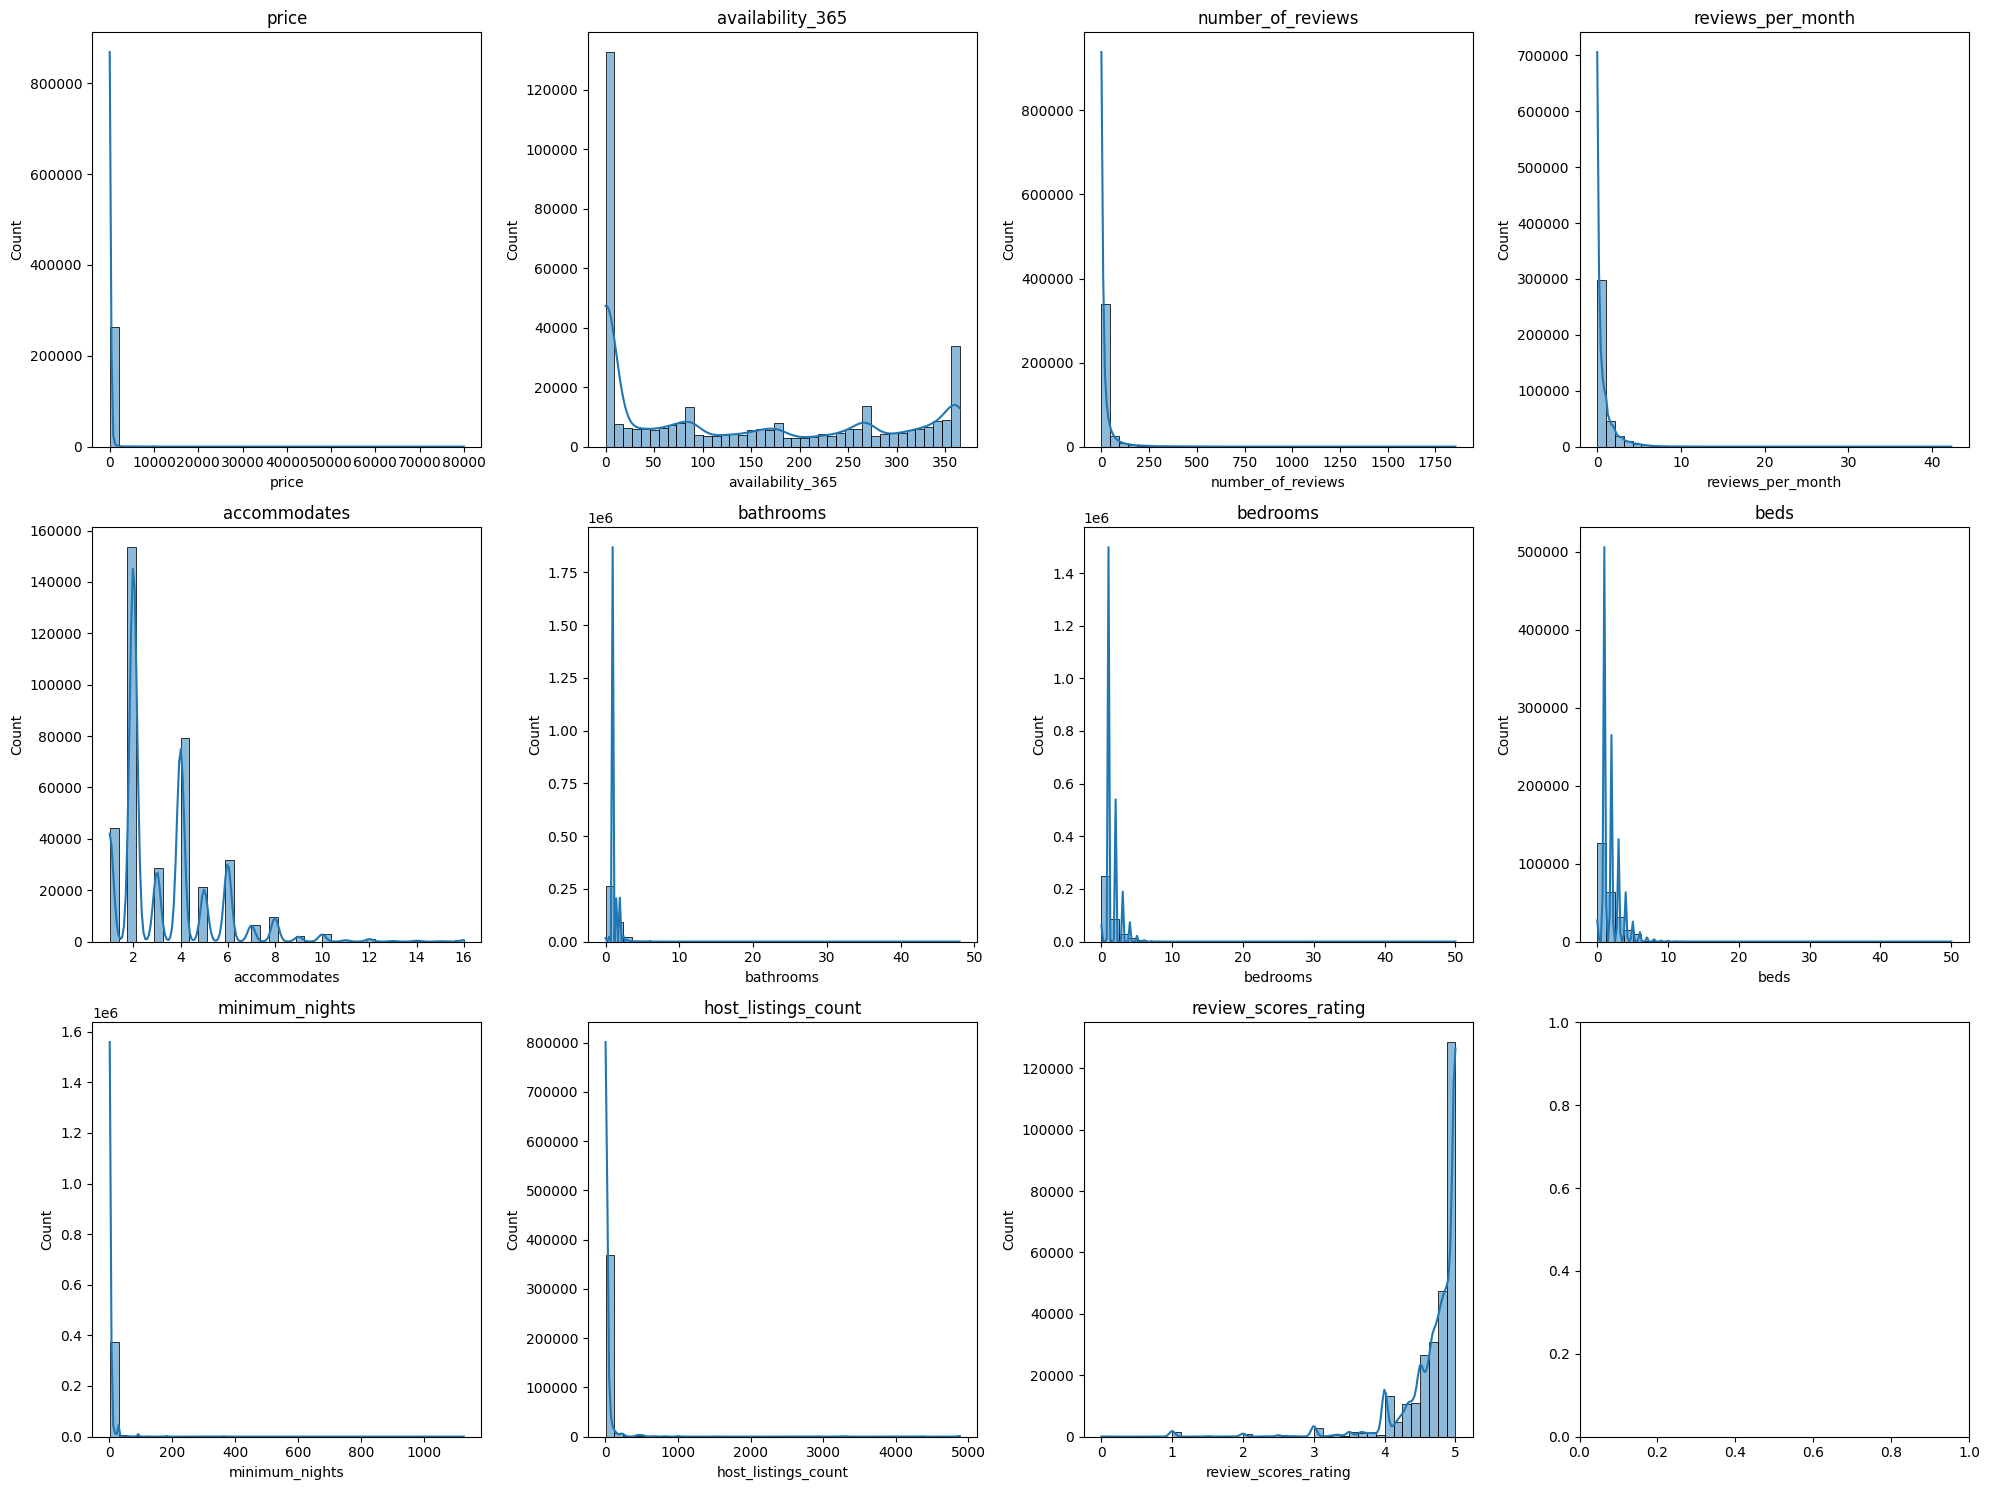

In [5]:
numeric_cols = ['price','availability_365','number_of_reviews','reviews_per_month','accommodates','bathrooms','bedrooms','beds','minimum_nights','host_listings_count','review_scores_rating']
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(airbnb_summary[col].dropna(), kde=True, bins=40, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


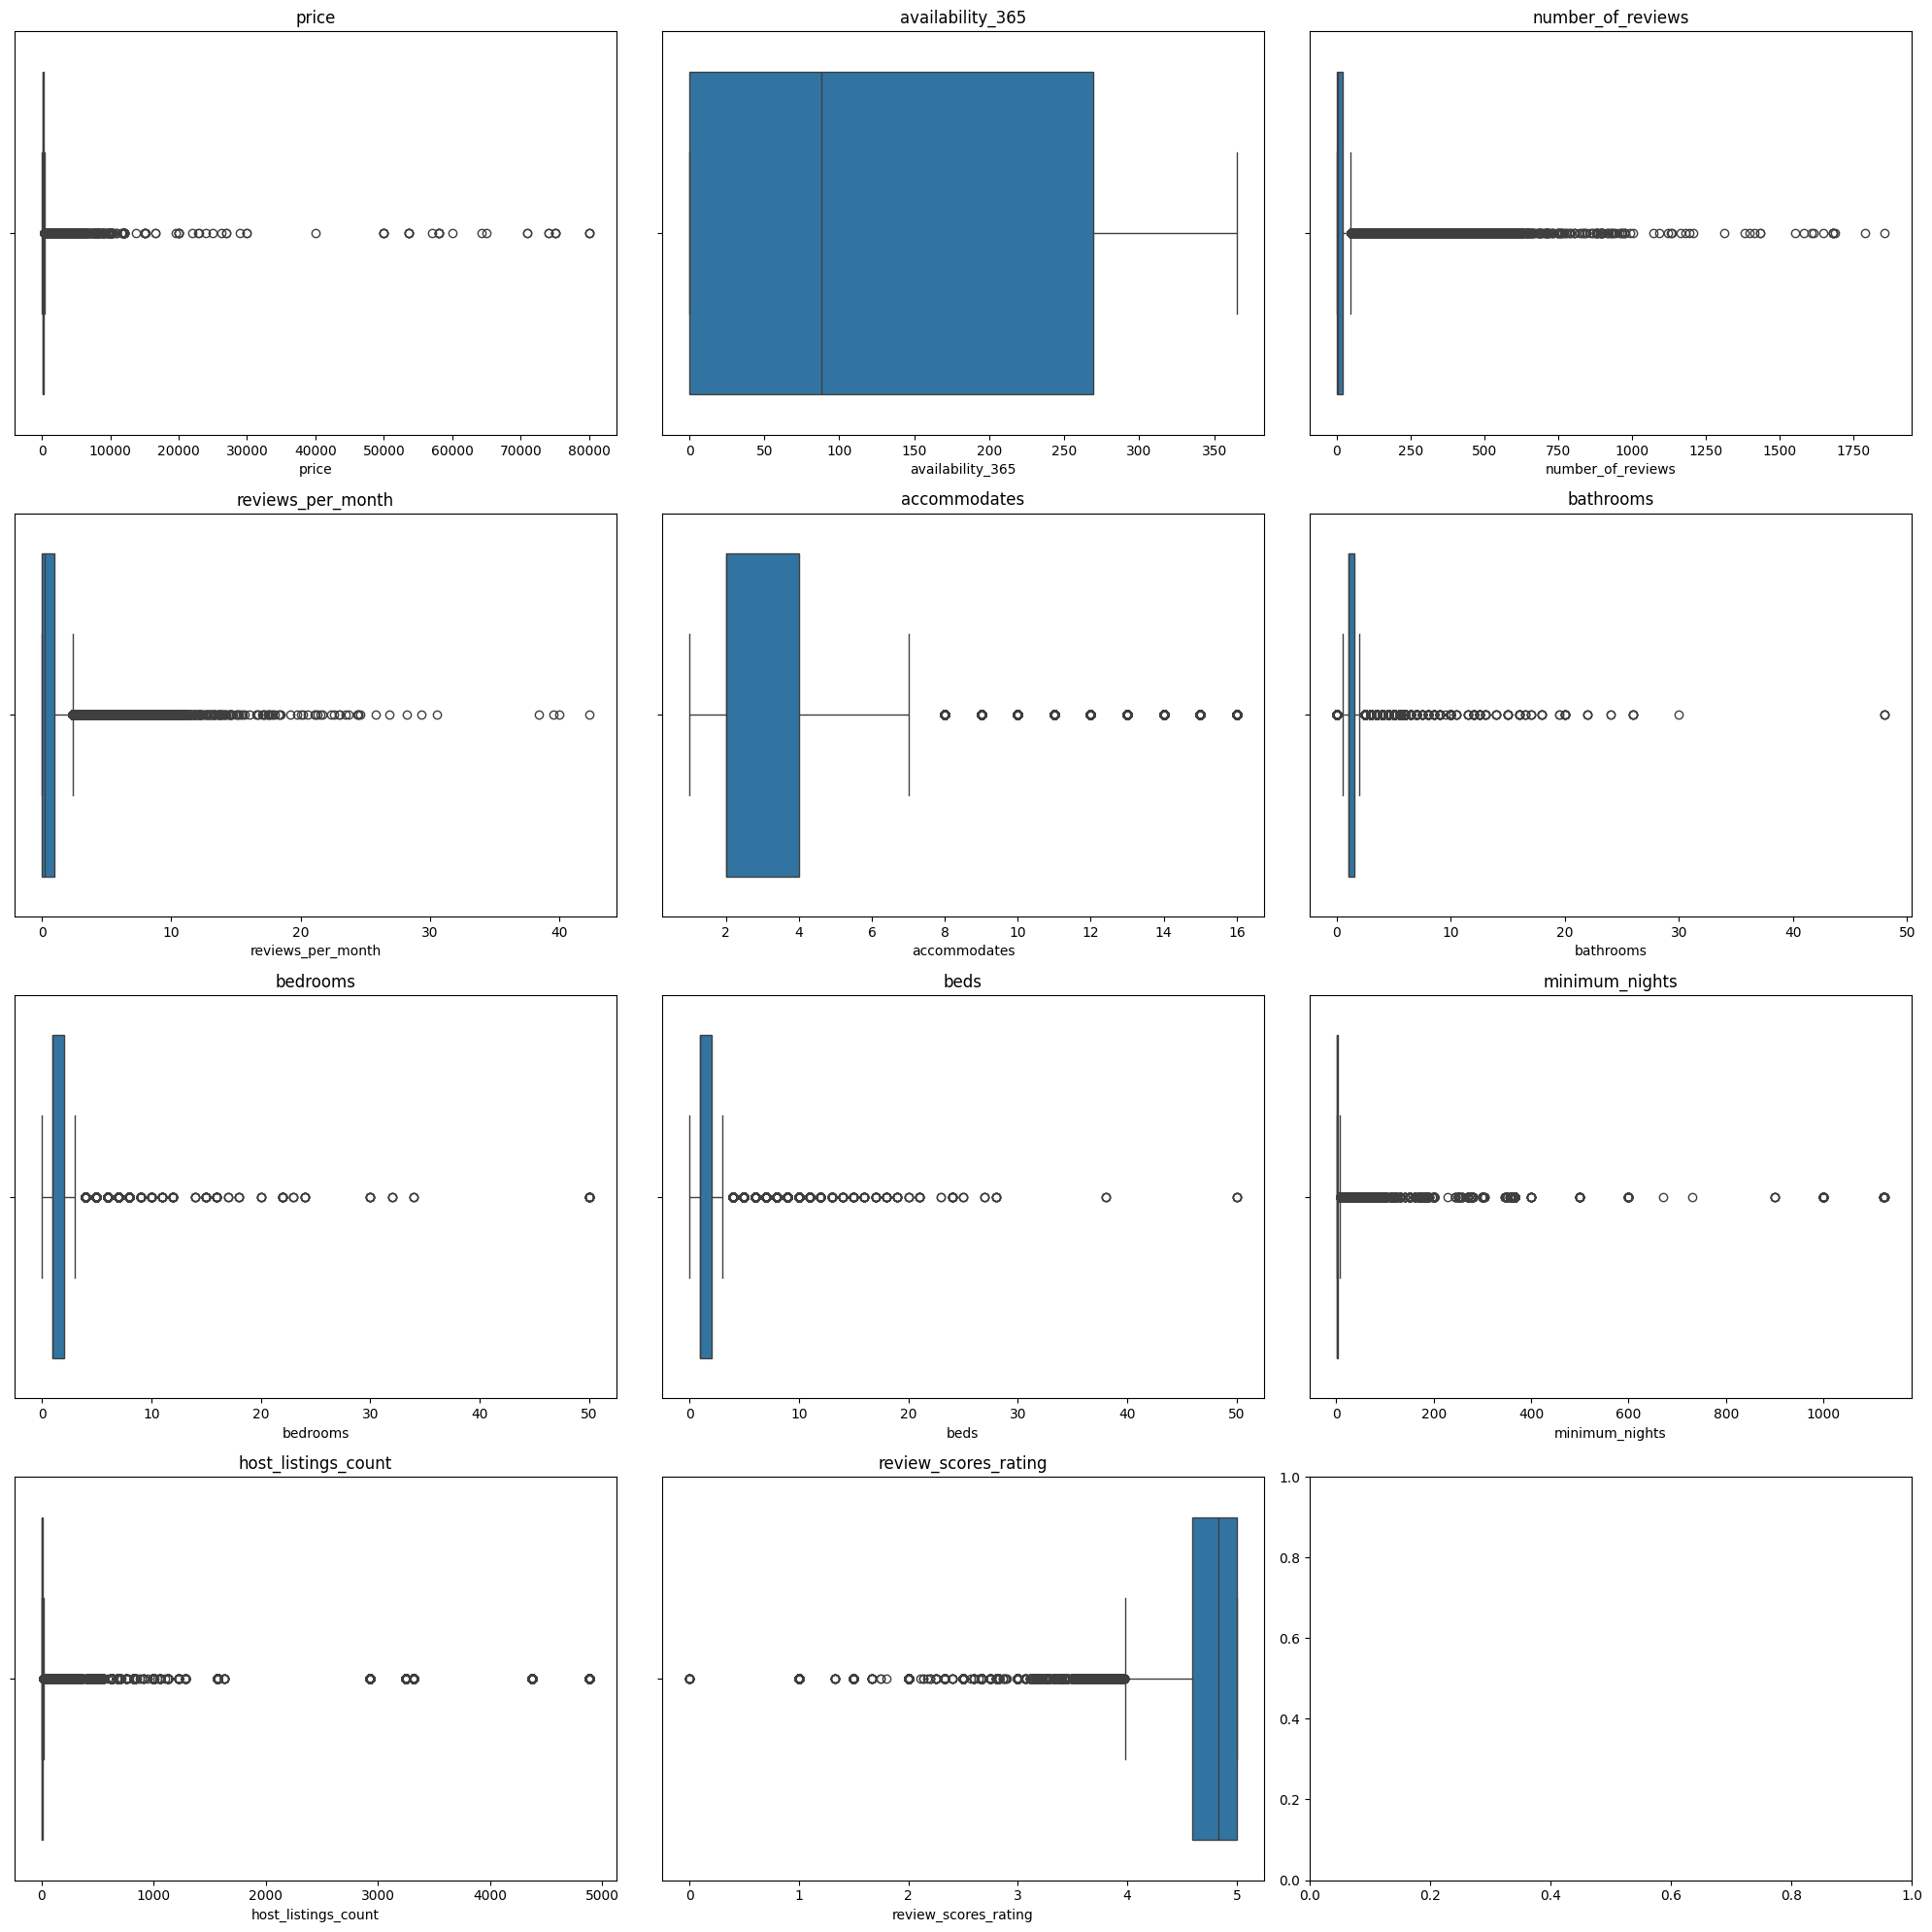

In [6]:
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=airbnb_summary[col], ax=axes[i])
    axes[i].set_title(f"{col}")

plt.tight_layout()
plt.show()


Insights :
- number_of_reviews - Few listings have 1000+ reviews, a small subset of listings dominate review activity (likely high booking volume).
- reviews_per_month - is heavily right-skewed suggesting few listings have high reviews (high activity probably)
- availibilty_365- Many listings are vailable almost all year.
- Acommodates - Most liistings accomodate 2-4 ,Market is primarily small group oriented.
- host_listings_count- is heavily skewed ,most host have listings in thousands some have fewer listing too suggesting (individual and commercial hosts).
- review_scores_rating- Most ratings are toward 4.5 -5.0 .

- Most of numeric variables exhibit right-skewed behaviour.
with heacy presence of outliners.For analysis its better to use medain over mean.

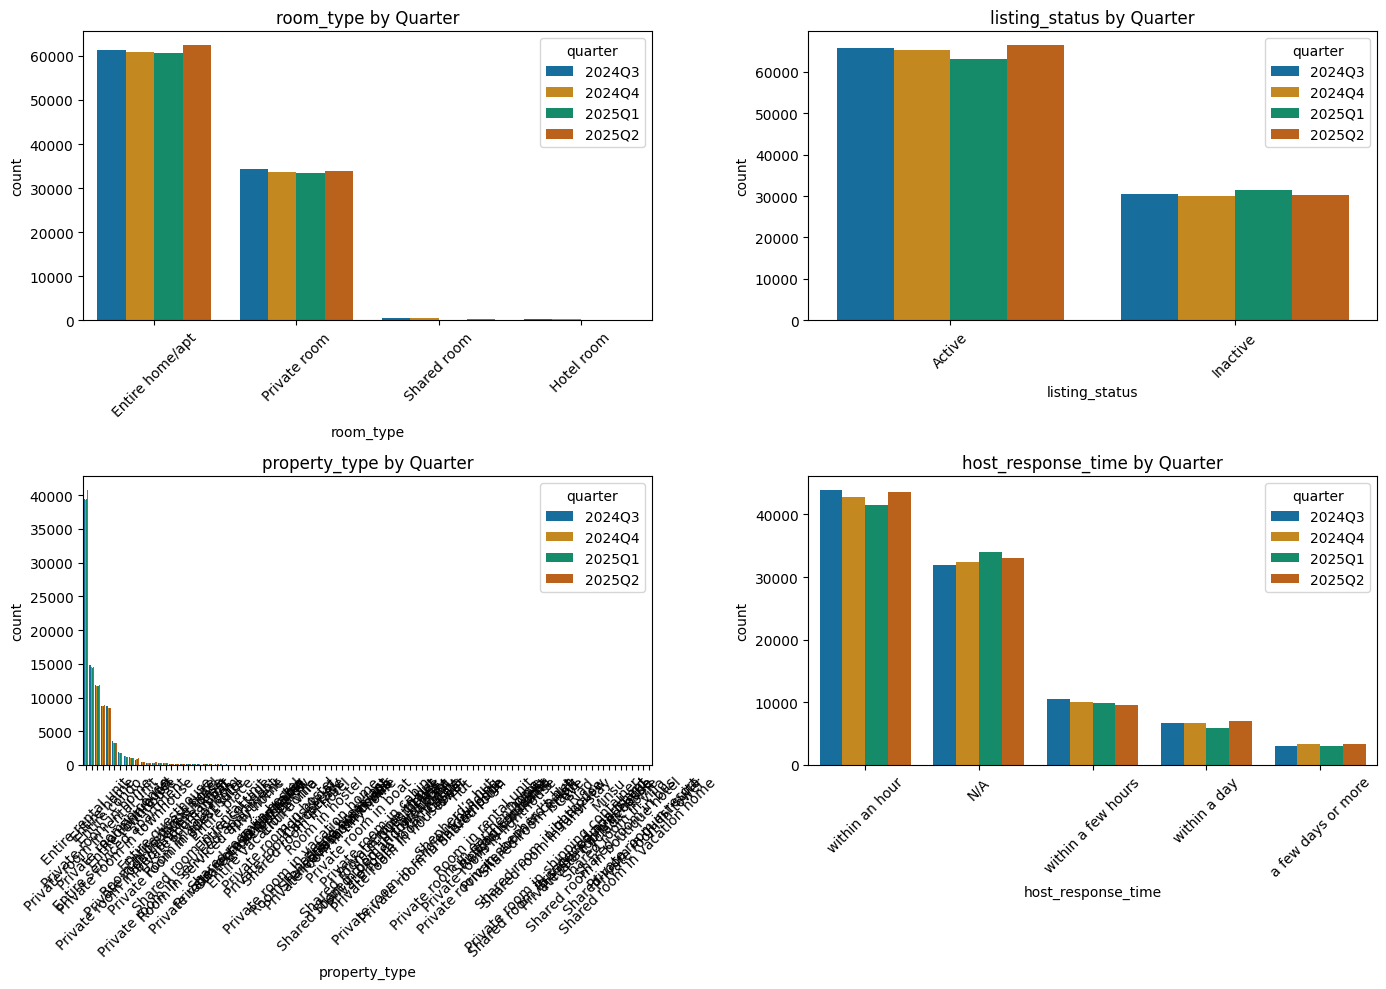

In [7]:
categorical_cols = ["room_type","listing_status","property_type","host_response_time"]

n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    order = airbnb_summary[col].value_counts().index
    
    sns.countplot(data=airbnb_summary,x=col, hue="quarter",   order=order,palette="colorblind", ax=axes[i])
    
    axes[i].set_title(f"{col} by Quarter")
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplot if odd number
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- London airbnb market is heavily skewed towards entire homes/apt indicating strong demand for full unit share rather than shared accomodation .
- Majority of listings are active throughout the quarters .
- Service quality indicator - There are large number of hosts that respond within an hour indicating high booking conversion rates .

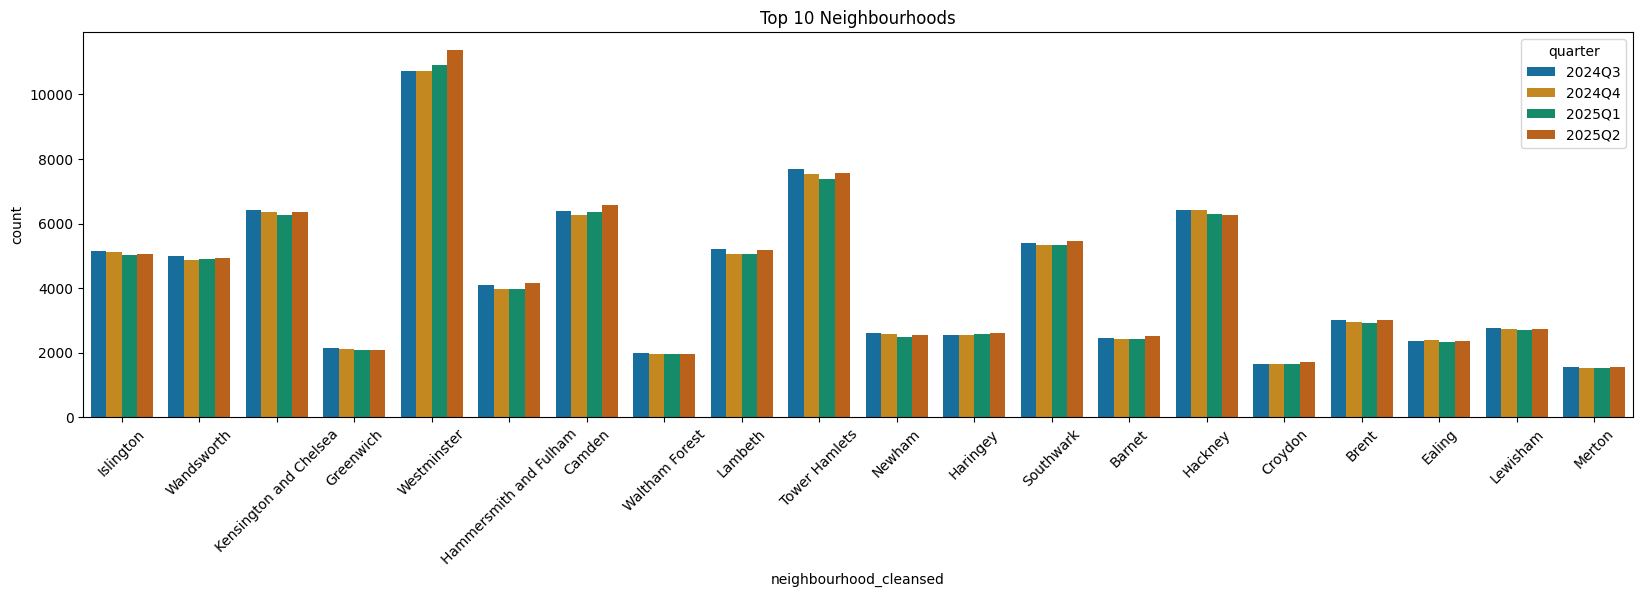

In [8]:
top_neigh = airbnb_summary["neighbourhood_cleansed"].value_counts().head(20).index

plt.figure(figsize=(20,5))
sns.countplot(
    data=airbnb_summary[airbnb_summary["neighbourhood_cleansed"].isin(top_neigh)], x="neighbourhood_cleansed",hue="quarter",palette="colorblind")

plt.xticks(rotation=45)
plt.title("Top 10 Neighbourhoods")
plt.show()

***Airbnb supply(listings) concentrated and how is it changing over time/ Market place structure Insights:***
- Westminster has highest number of listings. Also westminster has increased listing count in quarter 2 maybe because its peak season .We'll investigate this further.
- Then Tower Hamlets,Camden.
- Suggest supply is highly concentrated in a few central boroughs.
- Moreover ,in bouroughs with high supply ,hosts compete more,rating and pricing strategy matter more.

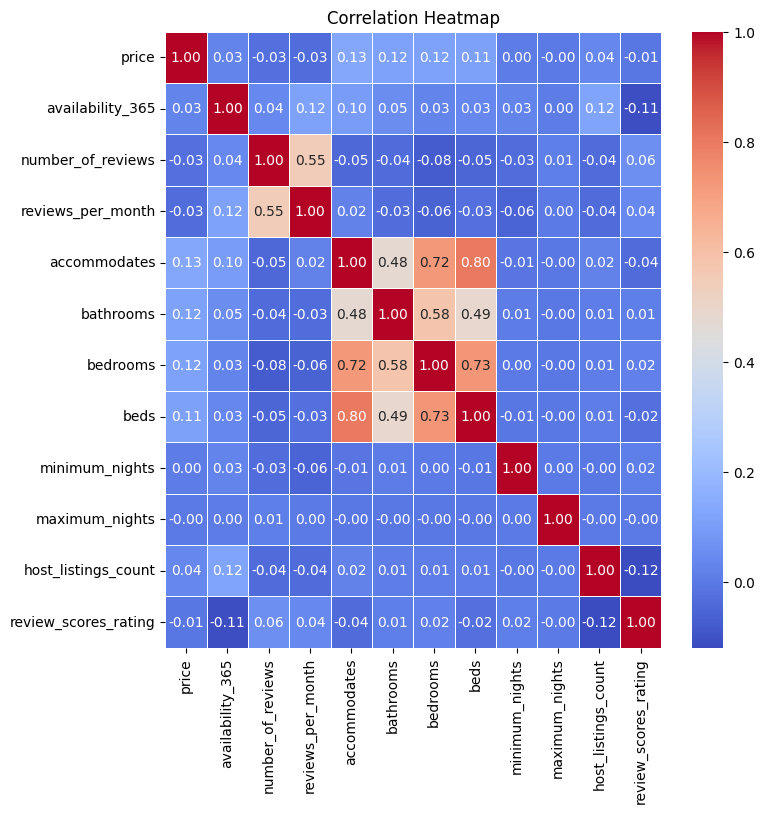

In [9]:
numeric_cols = ['price','availability_365','number_of_reviews','reviews_per_month','accommodates','bathrooms','bedrooms','beds','minimum_nights','maximum_nights','host_listings_count','review_scores_rating']

# Select from dataframe
numeric_df = airbnb_summary[numeric_cols]

# Correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8,8))
sns.heatmap( corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.show()

### ***Insight***
From the correlation ,we didn't get to know any significant correlation between numeric variable.

# ***Business Problem***

## ***Pricing***

### ***1. Business Question***
What is the typical nightly rate trend across quarters or Median nightly price of *active listings* in each quarter?

### ***2. Why It Matters?***
Understanding price stability helps determine whether revenue changes are driven by pricing behavior or demand fluctuations.


In [ ]:
# Filter only active listings
active = airbnb_summary[(airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()
active_listing_price=active[active["price"].notna()]
median_price_per_quarter=(active_listing_price.groupby("quarter")["price"].median().reset_index(name="median_price"))
median_price_per_quarter

,quarter,median_price
0,2024Q3,131.0
1,2024Q4,135.0
2,2025Q1,122.0
3,2025Q2,135.0


### ***Key Findings***
- Prices remain stable around (130–134)pounds, except in Q1 2025 (£120).
- Indicates a seasonal dip in winter demand, with recovery in spring.
### ***Businesss Insight***
Pricing remains relatively stable across quarters, suggesting that revenue volatility is unlikely to be price-driven.
The Q1 dip indicates possible seasonal discounting during winter demand slowdown.

## ***Occupancy***

### ***1. Business Question***

How does occupancy vary across quarters, and does seasonality influence listing utilization?

### ***2. Why It Matters***

Occupancy directly drives revenue performance.
If revenue fluctuates while pricing remains stable, demand (occupancy) is likely the primary driver of revenue volatility.

Understanding seasonal utilization patterns helps Airbnb:Forecast demand, Optimize pricing strategy, Plan supply onboarding

In [11]:
active = airbnb_summary[(airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()

active["booked_days_30"] = airbnb_summary["occ_rate_30"] * 30

quarter_occ = (
    active.groupby("quarter")
    .agg(
        total_booked_days=("booked_days_30","sum"),
        total_listings=("id","count")
    )
    .reset_index()
)

quarter_occ["quarter_occ_rate"] = (quarter_occ["total_booked_days"] /(quarter_occ["total_listings"] * 30))
quarter_occ

,quarter,total_booked_days,total_listings,quarter_occ_rate
0,2024Q3,1035317.0,65670,0.525515
1,2024Q4,995570.0,65204,0.508951
2,2025Q1,851943.0,63054,0.450377
3,2025Q2,1203773.0,66488,0.603504


### ***3. Key Findings***

Q2 2025 shows the highest median occupancy (~ 60%)

Q1 2025 shows the lowest occupancy (~43%)

Clear seasonal pattern:
Q2 > Q3 > Q4 > Q1

Active listings remain relatively stable across quarters

### ***4. Business Insight***

Revenue volatility is strongly demand-driven.

While pricing remains relatively stable, occupancy drops significantly in Q1, leading to weaker revenue performance during winter months.

This indicates:

Seasonality is a major revenue driver

Q1 represents a recurring demand dip

Q2 captures peak utilization

Strategic implication:
Airbnb should focus on demand stimulation strategies before Q1 (e.g., targeted promotions or seasonal pricing adjustments).

## ***Revenue***

### ***1. Business Question***

How does overall market revenue fluctuate across quarters, and what drives these changes?

### ***2. Why It Matters***

Revenue is the primary business performance metric.

While price indicates supply strategy and occupancy reflects demand, revenue captures the combined effect of both.

Understanding revenue seasonality helps:

Provides a foundation for seasonal demand forecasting and strategic planning
Identify peak and weak demand cycles

Guide pricing and marketing interventions

(Median used to reduce impact of outliers.)

In [12]:
active = airbnb_summary[
    (airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()

#  Group by quarter → median revenue aproximately/proxy
revenue_qtr = (
    active.groupby("quarter")["revenue_quarter"]
    .median()
    .reset_index(name="median_revenue")
)
revenue_qtr  

,quarter,median_revenue
0,2024Q3,5040.0
1,2024Q4,5253.0
2,2025Q1,3618.0
3,2025Q2,6612.0


### ***3. Key Findings***

Q2 2025 records the highest median revenue (~£6,612)

Q1 2025 records the lowest median revenue (~£3,618)

Revenue ranking:
Q2 > Q4 > Q3 > Q1

Strong seasonal pattern observed

### ***4. Business Insight***
Revenue volatility is primarily demand-driven rather than price-driven.

From KPI 1:

Prices remain relatively stable across quarters.

From KPI 2:

Occupancy drops significantly in Q1 and peaks in Q2.

This explains revenue fluctuations:

Q1 revenue dip aligns with lowest occupancy.

Q2 revenue peak aligns with highest occupancy.

Strategic Implication:
Revenue growth strategies should focus more on improving occupancy during low-demand quarters rather than aggressive pricing adjustments.

### ***KPI 4: Room Type Contribution to Revenue & Occupancy/ Revenue concentration analysis***

### ***1. Business Question***

Which room types generate the highest revenue and maintain strong occupancy levels?
Is revenue and occupancy diversified across segments, or concentrated in specific room types?

### ***2. Why It Matters***

Understanding revenue concentration helps:

- Identify primary revenue drivers

- Detect if there is any structural dependency risk

- Inform listing supply strategy

- Guide investment and marketing allocation

In [13]:
active = airbnb_summary[
    (airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()


# Convert occupancy to booked days (for solid occupancy calc)
active["booked_days_30"] = active["occ_rate_30"] * 30

# Step 5: Group by room_type
room_summary = (
    active.groupby("room_type")
    .agg(
        total_revenue=("revenue_quarter", "sum"),
        total_booked_days=("booked_days_30", "sum"),
        total_listings=("id", "count")
    )
    .reset_index()
)

room_summary["total_possible_days"] = room_summary["total_listings"] * 30

# occupancy (booked days / possible days)
room_summary["occ_rate"] = (room_summary["total_booked_days"] / (room_summary["total_possible_days"]))

# Revenue share
room_summary["revenue_share"] = (room_summary["total_revenue"] / room_summary["total_revenue"].sum())
room_summary["occ_rate"] *= 100
room_summary["revenue_share"] *= 100

room_summary = room_summary.sort_values("total_revenue", ascending=False)

room_summary


,room_type,total_revenue,total_booked_days,total_listings,total_possible_days,occ_rate,revenue_share
0,Entire home/apt,1.941922e+09,2932356.0,174425,5232750,56.038527,87.125863
2,Private room,2.755664e+08,1141724.0,84621,2538630,44.974021,12.363501
1,Hotel room,1.010293e+07,7096.0,513,15390,46.107862,0.453276
3,Shared room,1.278492e+06,5427.0,857,25710,21.108518,0.057361


### ***4. Key Findings***

Entire home/apartment contributes 87.2% of total revenue

Highest median occupancy (~ 57 %)

Private rooms contribute ~ 45.5%

Hotel rooms and shared rooms contribute ~ 47.4 % combined

Shared rooms show extremely low occupancy (~ 23 %)

Revenue is heavily concentrated in one category (Entire home/apt).

### ***5. Business Insight***

The marketplace is structurally dependent on Entire Home/Apt listings, which drive both occupancy(56 %) and revenue(87 %).

While this segment is the core growth engine, it creates concentration risk. Expanding high-performing private room listings could diversify revenue and reduce dependency.

Low shared room performance suggests weak demand base on occupancy(22 %)

### ***KPI 5: Property Type Contribution to Revenue & Occupancy/ Which specific property configurations drive the business?***

### ***1. Business Question***

Which specific room type * property type combinations generate the highest revenue and occupancy?

or

What exact listing configurations drive marketplace performance?

### ***2. Why It Matters***

Understanding performance at more granular level helps :

- Identify high-performing supply categories.

- optimize host - onboarding for particular property* room type.

In [14]:
active = airbnb_summary[ (airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()
#  LISTING-LEVEL METRIC
active["booked_days_30"] = active["occ_rate_30"] * 30

# GROUP (room_type * property_type) -
combo = (
    active.groupby(["room_type", "property_type"])
          .agg(
              observations=("id", "count"),   # count rows (quarters)
              listings=("id","nunique"),
              total_booked_days=("booked_days_30", "sum"),
              total_revenue=("revenue_quarter", "sum")
          )
          .reset_index()
)

#  TRUE OCCUPANCY
combo["total_possible_days"] = combo["observations"] * 30

combo["occ_rate"] = ( combo["total_booked_days"] /combo["total_possible_days"])

#  REVENUE SHARE 
combo["revenue_share_%"] = (combo["total_revenue"] /combo["total_revenue"].sum() * 100).round(4)

# TOP 10 
combo_top10 = (combo.sort_values("total_revenue", ascending=False).head(20).copy())

combo_top10


,room_type,property_type,observations,listings,total_booked_days,total_revenue,total_possible_days,occ_rate,revenue_share_%
21,Entire home/apt,Entire rental unit,110529,46775,1859028.0,1.169784e+09,3315870,0.560646,52.4833
17,Entire home/apt,Entire home,24310,9610,388989.0,3.352765e+08,729300,0.533373,15.0424
13,Entire home/apt,Entire condo,26301,10071,466834.0,2.659760e+08,789030,0.591656,11.9332
69,Private room,Private room in rental unit,29906,11944,411981.0,1.147866e+08,897180,0.459195,5.1500
22,Entire home/apt,Entire serviced apartment,6495,2197,102660.0,7.587204e+07,194850,0.526867,3.4041
61,Private room,Private room in home,31826,11618,400112.0,7.266471e+07,954780,0.419062,3.2602
23,Entire home/apt,Entire townhouse,2668,938,51557.0,5.992313e+07,80040,0.644140,2.6885
55,Private room,Private room in condo,10290,3834,160652.0,3.623500e+07,308700,0.520415,1.6257
83,Private room,Room in hotel,3235,1171,35102.0,1.569837e+07,97050,0.361690,0.7043
76,Private room,Private room in townhouse,3215,1042,53468.0,1.080183e+07,96450,0.554360,0.4846


In [15]:
combo_last10 = (combo.sort_values("total_revenue", ascending=False).tail(10).copy())
combo_last10

,room_type,property_type,observations,listings,total_booked_days,total_revenue,total_possible_days,occ_rate,revenue_share_%
100,Shared room,Shared room in villa,3,1,23.0,1932.0,90,0.255556,0.0001
54,Private room,Private room in chalet,5,2,5.0,1920.0,150,0.033333,0.0001
73,Private room,Private room in shipping container,4,1,4.0,1230.0,120,0.033333,0.0001
86,Shared room,Shared room in boutique hotel,2,1,6.0,873.0,60,0.100000,0.0000
70,Private room,Private room in resort,2,1,4.0,810.0,60,0.066667,0.0000
87,Shared room,Shared room in bungalow,5,2,4.0,738.0,150,0.026667,0.0000
31,Entire home/apt,Religious building,2,1,1.0,636.0,60,0.016667,0.0000
65,Private room,Private room in lighthouse,4,1,4.0,612.0,120,0.033333,0.0000
32,Entire home/apt,Riad,4,1,0.0,0.0,120,0.000000,0.0000
80,Private room,Private room in yurt,4,1,0.0,0.0,120,0.000000,0.0000


C:\Users\HP\AppData\Local\Temp\ipykernel_210716\2024670287.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combo_top10["label"], rotation=45, ha="right")


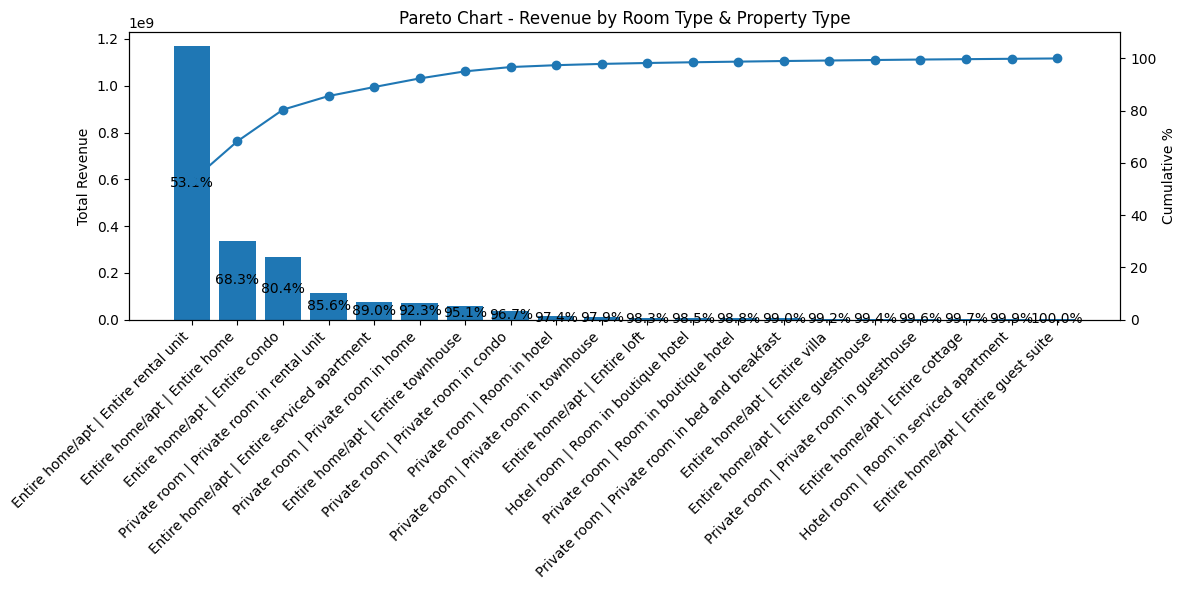

In [16]:

# SORT DATA 
combo_top10 = combo_top10.sort_values("total_revenue", ascending=False).copy()

# CALCULATE CUMULATIVE % 
combo_top10["cum_percentage"] = (
    combo_top10["total_revenue"].cumsum() / combo_top10["total_revenue"].sum() * 100
)

# Create label for x-axis
combo_top10["label"] = combo_top10["room_type"] + " | " + combo_top10["property_type"]

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Bars (Revenue)
bars = ax1.bar(combo_top10["label"], combo_top10["total_revenue"])
ax1.set_ylabel("Total Revenue")
ax1.set_xticklabels(combo_top10["label"], rotation=45, ha="right")

# Line (Cumulative %)
ax2 = ax1.twinx()
ax2.plot(combo_top10["label"], combo_top10["cum_percentage"], marker="o")
ax2.set_ylabel("Cumulative %")
ax2.set_ylim(0, 110)

# ADD CUM % LABELS ON BARS 
for i, (bar, cum) in enumerate(zip(bars, combo_top10["cum_percentage"])):
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()*0.5,
        f"{cum:.1f}%",
        ha='center',
        va='center',
        rotation=0  # make vertical
    )

plt.title("Pareto Chart - Revenue by Room Type & Property Type")
plt.tight_layout()
plt.show()


### ***Pareto Principle***
Of all the 100 combinations ,top 3 combinations  alone drive 80 % of revenue.Hence it follows pareto principle.

### ***3. Key Findings***
Entire home/apt – Entire rental unit
-> ~53% revenue share alone

Entire home/apt – Entire home
-> ~15%

Entire home/apt – Entire condo
-> ~12%

Together, these 3 configurations drive ~80% + of revenue.

Private room – rental unit contributes modestly (~5%).

Revenue is highly concentrated within full-property rental formats.

### ***4. Business Insight***

The business is not just dependent on “Entire Home” listings —
it is specifically dependent on entire rental units and full-property accommodations.

This suggests:

Guests prefer fully private spaces over shared formats

The marketplace behaves more like a traditional short-term rental platform than a room-sharing platform

Supply expansion strategy should prioritize the onboarding of top 3 (property type and room type)combination found .

### ***Neighbourhood occupancy and Revenue share***

### ***1. Business Question***

Which neighbourhoods drive the highest revenue and occupancy?
Is marketplace performance geographically concentrated?

### ***2. Why It Matters***

Understanding geographic concentration helps:

- Identify prime revenue districts

- Optimize marketing spend geographically

- Guide host acquisition strategy

- Detect overdependence on central locations

- Location is one of the strongest demand drivers in short-term rentals.

In [21]:
# ACTIVE LISTINGS 
active = airbnb_summary[ (airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()

#  LISTING-LEVEL METRICS active["occ_rate_30"],active["booked_days_30"],active["revenue_quarter"]
active["booked_days_30"] = active["occ_rate_30"] * 30

# GROUP (room_type * property_type) 
combo = (
    active.groupby(["neighbourhood_cleansed"])
          .agg(
              observations=("id", "count"),   # count rows (quarters)
              listings=("id","nunique"),
              total_booked_days=("booked_days_30", "sum"),
              total_revenue=("revenue_quarter", "sum"),
              price=("price","mean")
          )
          .reset_index()
)

#  TRUE OCCUPANCY 
combo["total_possible_days"] = combo["observations"] * 30

combo["occ_rate"] = ( combo["total_booked_days"] / combo["total_possible_days"])

#  REVENUE SHARE 
combo["revenue_share_%"] = (combo["total_revenue"] /combo["total_revenue"].sum() * 100).round(4)

#  TOP 10 
combo_top10 = ( combo.sort_values("total_revenue", ascending=False).head(20).copy())

combo_top10


,neighbourhood_cleansed,observations,listings,total_booked_days,total_revenue,price,total_possible_days,occ_rate,revenue_share_%
32,Westminster,33807,13588,576847.0,477946275.0,315.162097,1014210,0.568765,21.4434
19,Kensington and Chelsea,19549,7658,319992.0,286493539.5,327.372270,586470,0.545624,12.8538
5,Camden,18130,7201,320392.0,194331732.0,212.142416,543900,0.589064,8.7188
29,Tower Hamlets,18474,7583,304986.0,128068809.0,155.248566,554220,0.550298,5.7459
18,Islington,11835,4616,213372.0,115798233.0,196.758851,355050,0.600963,5.1954
21,Lambeth,12483,4859,213322.0,113709532.5,266.269046,374490,0.569633,5.1017
27,Southwark,13369,5357,231291.0,111197169.0,175.092004,401070,0.576685,4.9889
11,Hackney,13594,5265,243670.0,108100320.0,160.789613,407820,0.597494,4.8500
31,Wandsworth,12477,4866,202732.0,105825894.0,189.031258,374310,0.541615,4.7480
12,Hammersmith and Fulham,10902,4355,185105.0,101510604.0,188.552284,327060,0.565966,4.5544


### ***4. Key Findings***
Westminster contributes ~21.6% of total revenue

Kensington & Chelsea contributes ~12.9%

Camden contributes ~8.7%

Top 3 neighbourhoods together ≈ 43%+ of total revenue

Occupancy across top districts remains consistently strong (~57–59%).

Also listing price in Westminster and Kensington & Chelsea is >200 .

Revenue declines sharply beyond top districts.

### ***5. Business Insight***

Looking at the revneue concentration in Westminster, Kensington & Chelsea , Camden (~43 % revenue ) , occupancy around (57 -59 %) and price above 200 suggests
Revenue is geographically concentrated in central, premium districts.

This indicates:

- ***Strong tourist demand*** in core central areas /The marketplace performance is structurally tied to high-value central London locations.

- ***Higher pricing power*** in prime neighbourhoods

- Potential saturation risk in top districts

- Opportunity for airbnb demand expansion in mid-tier areas contributing to more revenue/occupancy.

This creates:

Pricing advantage, but regulatory and competition exposure

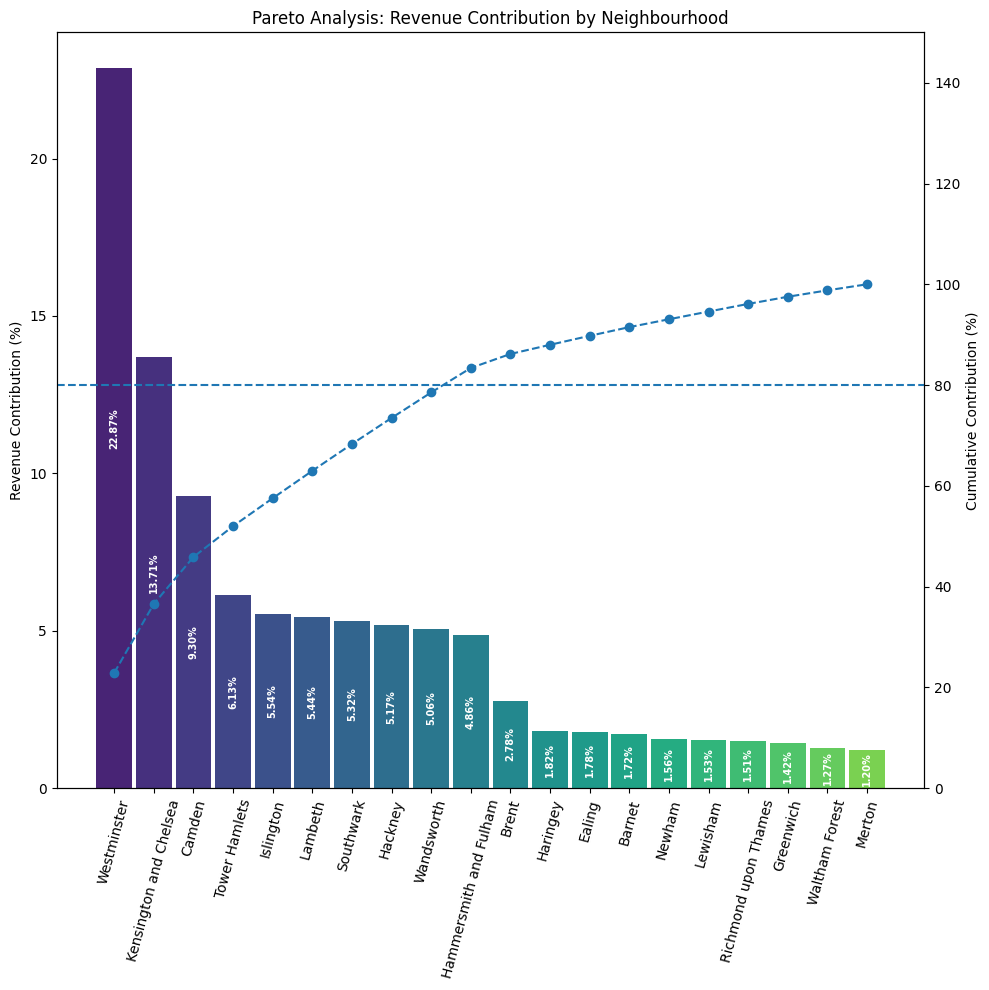

In [22]:

# Sort
room_summary = combo_top10.sort_values(by="total_revenue",ascending=False).reset_index(drop=True)

# Contribution %
room_summary["contribution_%"] = (room_summary["total_revenue"] /room_summary["total_revenue"].sum() * 100)

# Cumulative %
room_summary["cumulative_%"] = room_summary["contribution_%"].cumsum()

fig, ax1 = plt.subplots(figsize=(10,10))

# ---- Dark gradient colors (like your picture) ----
colors = plt.cm.viridis( np.linspace(0.1, 0.8, len(room_summary)))

bars = ax1.bar(
    room_summary["neighbourhood_cleansed"],
    room_summary["contribution_%"],
    color=colors,
    width=0.9
)

ax1.set_ylabel("Revenue Contribution (%)")
plt.xticks(rotation=75)

# ---- Horizontal white labels INSIDE bars ----
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height/2,
        f"{height:.2f}%",
        ha='center',
        va='center',
        color="white",
        fontsize=7,
        fontweight="bold",
        rotation=90  # keeps text horizontal
    )

# ---- Cumulative Line ----
ax2 = ax1.twinx()
ax2.plot(
    room_summary["neighbourhood_cleansed"],
    room_summary["cumulative_%"],
    marker="o",
    linestyle="--"
)

ax2.set_ylabel("Cumulative Contribution (%)")
ax2.set_ylim(0, 150)

# 80% reference line
ax2.axhline(80, linestyle="--")

plt.title("Pareto Analysis: Revenue Contribution by Neighbourhood")
plt.tight_layout()
plt.show()


- Does not follow pareto principle
- The top 20% of neighbourhoods contribute roughly 60% of total revenue, indicating moderate concentration rather than a classic 80/20 distribution.

### ***host_response_time***

airbnb_summary['host_response_time'].unique()

### ***1. Business Question***
Is  host reponse time primary factor for roccupancy and revenue?
### ***2. Why it matters***
If host response time has relation with occupancy then we can encourge host communication with guests ,thereby increasing occupancy,also it will increase reviews.

In [18]:
active = airbnb_summary[(airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()

#  booked_days_30
active["booked_days_30"] = active["occ_rate_30"] * 30

#  Group by room_type
host_summary = (
    active.groupby("host_response_time")
    .agg( observations=("id", "count"),   # count rows (quarters)
          total_booked_days=("booked_days_30", "sum"),
         median_revenue=("revenue_quarter","median"),
         total_revenue=("revenue_quarter","sum"))
    .reset_index()
)

#  TRUE OCCUPANCY 
host_summary["total_possible_days"] = host_summary["observations"] * 30

host_summary["occ_rate"] = (host_summary["total_booked_days"] /host_summary["total_possible_days"])

# REVENUE SHARE 
host_summary["revenue_share_%"] = (host_summary["total_revenue"] /host_summary["total_revenue"].sum() * 100).round(4)

host_response_summary=host_summary[['host_response_time','occ_rate','revenue_share_%']]
host_response_summary.sort_values(ascending=False,by='revenue_share_%')

,host_response_time,occ_rate,revenue_share_%
4,within an hour,0.564362,65.7878
3,within a few hours,0.560733,13.7449
2,within a day,0.524982,9.4992
0,N/A,0.370287,8.7998
1,a few days or more,0.290125,2.1682


### ***3. Key Finding***
Fast response (within an hour) has big proportion in revenue and occupancy.
### ***4. Business Insight***
- This is operational discipline driving financial performance. Responsiveness is a critical performance driver.
- Faster communication = more trust = more bookings = more revenue.

### ***host experience***

### ***1. Business Question***
How does host experience (tenure) impact booking performance and revenue generation to identify high-performing segments and growth opportunities?

In [19]:
# Convert to datetime (if not already)
airbnb_summary["host_since"] = pd.to_datetime(airbnb_summary["host_since"])

# Calculate tenure in years
today = pd.Timestamp.today()

airbnb_summary["host_tenure"] = (
    (today - airbnb_summary["host_since"]).dt.days / 365
).round(1)
def classify_tenure(x):
    if x <= 5:
        return "Early (2-5)yr"
    elif x <= 8:
        return "Growing (5-8)yr"
    elif x <= 12:
        return "Experienced (8-12)yr"
    else:
        return "Veteran (12+)yr"

airbnb_summary["host_tenure_category"] = airbnb_summary["host_tenure"].apply(classify_tenure)
# Active listings
active = airbnb_summary[(airbnb_summary["listing_status"] == "Active") & (airbnb_summary["price"].notna())].copy()

# booked_days_30
active["booked_days_30"] = active["occ_rate_30"] * 30

#  Group by room_type
host_summary = (
    active.groupby("host_tenure_category")
    .agg( observations=("id", "count"),   # count rows (quarters)
          total_booked_days=("booked_days_30", "sum"),
         median_revenue=("revenue_quarter","median"),
         total_revenue=("revenue_quarter","sum"))
    .reset_index()
)

#  TRUE OCCUPANCY
host_summary["total_possible_days"] = host_summary["observations"] * 30

host_summary["occ_rate"] = ( host_summary["total_booked_days"] / host_summary["total_possible_days"])

#  REVENUE SHARE
host_summary["revenue_share_%"] = (host_summary["total_revenue"] /host_summary["total_revenue"].sum() * 100).round(4)

host_response_summary=host_summary[['host_tenure_category','occ_rate','revenue_share_%']]
host_response_summary.sort_values(ascending=False,by='revenue_share_%')

,host_tenure_category,occ_rate,revenue_share_%
1,Experienced (8-12)yr,0.555879,39.5562
0,Early (2-5)yr,0.460788,27.7750
2,Growing (5-8)yr,0.507179,16.9827
3,Veteran (12+)yr,0.601007,15.6861


### ***2. Key Findings***
Experienced hosts operate more efficiently (higher occupancy),
40% revenue comes from one tenure group
### ***3. Business Insights***
The platform should ***invest in onboarding and training early-stage hosts*** to improve performance. 
Platform risk exists if experienced hosts churn. ***Retention strategy*** becomes critical here.

Uptill now we explored 
- Pricing trend
- Demand seasonality
- Revenue trend
- Market structure
- Revenue concentration
- Supply stability

This is:

- Strategic Market Analysis
- Host Profitability Insight
- Seasonal Performance Study

# ***Heatmap: Revenue by Neighbourhood & Quarter***

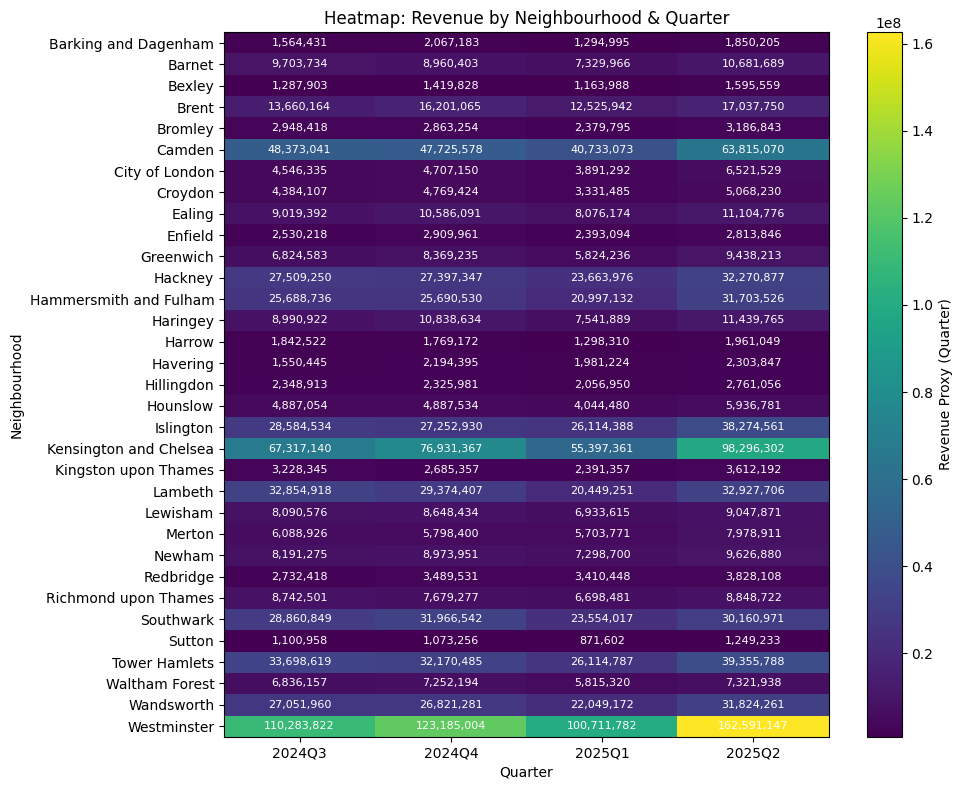

In [20]:

heatmap_df = (
    airbnb_summary
        .groupby(["neighbourhood_cleansed", "quarter"])
        .agg(total_revenue=("revenue_quarter", "sum"))
        .reset_index()
)
heatmap_pivot = heatmap_df.pivot( index="neighbourhood_cleansed", columns="quarter", values="total_revenue")

plt.figure(figsize=(10,8))

# Plot heatmap
im = plt.imshow(heatmap_pivot, aspect='auto')

plt.colorbar(im, label="Revenue Proxy (Quarter)")

plt.xticks(range(len(heatmap_pivot.columns)),heatmap_pivot.columns
)

plt.yticks( range(len(heatmap_pivot.index)), heatmap_pivot.index
)

#  ADD VALUES INSIDE EACH CELL
for i in range(len(heatmap_pivot.index)):
    for j in range(len(heatmap_pivot.columns)):
        value = heatmap_pivot.iloc[i, j]
        if not np.isnan(value):
            plt.text(
                j, i,
                f"{value:,.0f}",   # format with commas
                ha="center",
                va="center",
                fontsize=8,
                color="white"
            )

plt.title("Heatmap: Revenue by Neighbourhood & Quarter")
plt.xlabel("Quarter")
plt.ylabel("Neighbourhood")

plt.tight_layout()
plt.show()
